In [101]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy import sparse 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Xây dựng mô hình

In [102]:
def softmax_stable(Z):
    """
    Sử dụng softmax_stable để tránh tràn số  
    """
    e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
    A = e_Z / e_Z.sum(axis = 0)
    return A

def convert_labels(y, C):
    """
    Biến vector y thành ma trận one-hot
    """
    Y = sparse.coo_matrix((np.ones_like(y), 
        (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y 

def loss_function(X, Y, W):
    """
    Tính hàm mất mát cross-entropy loss
    """
    A = softmax_stable(W.T.dot(X))
    return -np.sum(Y*np.log(A))

def softmax_regression(X, y, W_init, eta, tol = 1e-4, max_count = 50000):
    """
    Softmax Regression sử dụng Stochastic Gradient Descent (SGD)
    """
    
    W = [W_init]    
    C = W_init.shape[1]
    Y = convert_labels(y, C)
    it = 0
    N = X.shape[1]
    d = X.shape[0]
    
    count = 0
    check_w_after = 20
    while count < max_count:
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)
            ai = softmax_stable(np.dot(W[-1].T, xi))
            W_new = W[-1] + eta*xi.dot((yi - ai).T)
            count += 1
            # Điều kiện dừng
            if count%check_w_after == 0:                
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
    return W

def pred(W, X):
    """
    Dự đoán nhãn cho tập dữ liệu X
    """
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis = 0)

# Áp dụng vào bài toán

## Chuẩn bị dữ liệu huấn luyện

In [103]:
# Đọc 3 file dữ liệu
df_original = pd.read_csv('data/obesity_data_cleaned.csv')
df_famd = pd.read_csv('data/obesity_famd_8D.csv')
df_lda = pd.read_csv('data/obesity_lda_4D.csv')

print("Dữ liệu gốc:", df_original.shape)
print("Dữ liệu FAMD 8D:", df_famd.shape)
print("Dữ liệu LDA 4D:", df_lda.shape)

Dữ liệu gốc: (20758, 21)
Dữ liệu FAMD 8D: (20758, 9)
Dữ liệu LDA 4D: (20758, 5)


In [104]:
# Chuẩn bị dữ liệu gốc
X_original = df_original.drop('NObeyesdad', axis=1).values
y = df_original['NObeyesdad'].astype('category').cat.codes.values

# Lấy index các cột liên tục để chuẩn hóa
continuous_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
continuous_idx = [df_original.drop('NObeyesdad', axis=1).columns.get_loc(col) for col in continuous_cols]

print("X_original shape:", X_original.shape)
print("y shape:", y.shape)
print("Continuous columns indices:", continuous_idx)

X_original shape: (20758, 20)
y shape: (20758,)
Continuous columns indices: [1, 2, 3, 6, 7, 10, 12, 13]


In [105]:
# Chuẩn bị dữ liệu FAMD và LDA
X_famd = df_famd.drop('NObeyesdad', axis=1).values
X_lda = df_lda.drop('NObeyesdad', axis=1).values

scaler_famd = StandardScaler()
X_famd = scaler_famd.fit_transform(X_famd)

print("X_famd shape:", X_famd.shape)
print("X_lda shape:", X_lda.shape)

X_famd shape: (20758, 8)
X_lda shape: (20758, 4)


In [106]:
# Chia dữ liệu thành 3 tập train-test với tỷ lệ 8/2, 7/3, 6/4
# Kịch bản 1: 80/20
X_train_orig_1, X_test_orig_1, y_train_1, y_test_1 = train_test_split(
    X_original, y, test_size=0.2, random_state=36, stratify=y)
X_train_famd_1, X_test_famd_1 = train_test_split(
    X_famd, test_size=0.2, random_state=36, stratify=y)
X_train_lda_1, X_test_lda_1 = train_test_split(
    X_lda, test_size=0.2, random_state=36, stratify=y)

# Kịch bản 2: 70/30
X_train_orig_2, X_test_orig_2, y_train_2, y_test_2 = train_test_split(
    X_original, y, test_size=0.3, random_state=36, stratify=y)
X_train_famd_2, X_test_famd_2 = train_test_split(
    X_famd, test_size=0.3, random_state=36, stratify=y)
X_train_lda_2, X_test_lda_2 = train_test_split(
    X_lda, test_size=0.3, random_state=36, stratify=y)

# Kịch bản 3: 60/40
X_train_orig_3, X_test_orig_3, y_train_3, y_test_3 = train_test_split(
    X_original, y, test_size=0.4, random_state=36, stratify=y)
X_train_famd_3, X_test_famd_3 = train_test_split(
    X_famd, test_size=0.4, random_state=36, stratify=y)
X_train_lda_3, X_test_lda_3 = train_test_split(
    X_lda, test_size=0.4, random_state=36, stratify=y)

print("Kịch bản 1 (80/20):")
print(f"  Train: {X_train_orig_1.shape[0]}, Test: {X_test_orig_1.shape[0]}")
print("Kịch bản 2 (70/30):")
print(f"  Train: {X_train_orig_2.shape[0]}, Test: {X_test_orig_2.shape[0]}")
print("Kịch bản 3 (60/40):")
print(f"  Train: {X_train_orig_3.shape[0]}, Test: {X_test_orig_3.shape[0]}")

Kịch bản 1 (80/20):
  Train: 16606, Test: 4152
Kịch bản 2 (70/30):
  Train: 14530, Test: 6228
Kịch bản 3 (60/40):
  Train: 12454, Test: 8304


In [107]:
#set seed
np.random.seed(912)

## Kịch bản 1 (train/test = 8/2)

### Dự đoán với dữ liệu gốc

In [108]:
# Chuẩn hóa dữ liệu gốc với các cột liên tục
scaler = StandardScaler()

X_train_orig_1_scaled = X_train_orig_1.copy()
X_test_orig_1_scaled = X_test_orig_1.copy()

X_train_orig_1_scaled[:, continuous_idx] = scaler.fit_transform(X_train_orig_1[:, continuous_idx])
X_test_orig_1_scaled[:, continuous_idx] = scaler.transform(X_test_orig_1[:, continuous_idx])

In [109]:
# Thêm bias cho dữ liệu gốc
X_train_1 = np.hstack([np.ones((X_train_orig_1_scaled.shape[0], 1)), X_train_orig_1_scaled])
X_test_1 = np.hstack([np.ones((X_test_orig_1_scaled.shape[0], 1)), X_test_orig_1_scaled])

print("X_train_1 shape:", X_train_1.shape)
print("X_test_1 shape:", X_test_1.shape)

X_train_1 shape: (16606, 21)
X_test_1 shape: (4152, 21)


In [110]:
# Khởi tạo tham số và huấn luyện mô hình với dữ liệu gốc
d = X_train_1.shape[1]
C = len(np.unique(y))
W_init = np.random.randn(d, C)

W = softmax_regression(X_train_1.T, y_train_1, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_1 = pred(W_final, X_test_1.T)

# Đánh giá mô hình
print(f"\nClassification Report (Dữ liệu gốc - Kịch bản 1):")
print(classification_report(y_test_1, y_pred_1))


Classification Report (Dữ liệu gốc - Kịch bản 1):
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       505
           1       0.78      0.79      0.79       617
           2       0.73      0.83      0.77       582
           3       0.93      0.93      0.93       650
           4       0.99      1.00      1.00       809
           5       0.70      0.58      0.63       485
           6       0.65      0.58      0.61       504

    accuracy                           0.83      4152
   macro avg       0.81      0.81      0.80      4152
weighted avg       0.82      0.83      0.82      4152



### FAMD về 8 chiều

In [111]:
# Thêm bias cho dữ liệu FAMD
X_train_1_famd = np.hstack([np.ones((X_train_famd_1.shape[0], 1)), X_train_famd_1])
X_test_1_famd = np.hstack([np.ones((X_test_famd_1.shape[0], 1)), X_test_famd_1])

print("X_train_1_famd shape:", X_train_1_famd.shape)
print("X_test_1_famd shape:", X_test_1_famd.shape)

X_train_1_famd shape: (16606, 9)
X_test_1_famd shape: (4152, 9)


In [112]:
# Khởi tạo tham số và huấn luyện mô hình với FAMD
d = X_train_1_famd.shape[1]
C = len(np.unique(y))
W_init = np.random.randn(d, C)

W = softmax_regression(X_train_1_famd.T, y_train_1, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_1_famd = pred(W_final, X_test_1_famd.T)

# Đánh giá mô hình
print(f"\nClassification Report (FAMD 8D - Kịch bản 1):")
print(classification_report(y_test_1, y_pred_1_famd))


Classification Report (FAMD 8D - Kịch bản 1):
              precision    recall  f1-score   support

           0       0.51      0.59      0.55       505
           1       0.49      0.18      0.27       617
           2       0.45      0.40      0.42       582
           3       0.52      0.84      0.64       650
           4       0.84      1.00      0.91       809
           5       0.37      0.28      0.32       485
           6       0.24      0.20      0.22       504

    accuracy                           0.54      4152
   macro avg       0.49      0.50      0.48      4152
weighted avg       0.51      0.54      0.51      4152



### LDA về 4 chiều

In [113]:
# Thêm bias cho dữ liệu LDA
X_train_1_lda = np.hstack([np.ones((X_train_lda_1.shape[0], 1)), X_train_lda_1])
X_test_1_lda = np.hstack([np.ones((X_test_lda_1.shape[0], 1)), X_test_lda_1])

print("X_train_1_lda shape:", X_train_1_lda.shape)
print("X_test_1_lda shape:", X_test_1_lda.shape)

X_train_1_lda shape: (16606, 5)
X_test_1_lda shape: (4152, 5)


In [114]:
# Khởi tạo tham số và huấn luyện mô hình với LDA
d = X_train_1_lda.shape[1]
C = len(np.unique(y))
W_init = np.random.randn(d, C)

W = softmax_regression(X_train_1_lda.T, y_train_1, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_1_lda = pred(W_final, X_test_1_lda.T)

# Đánh giá mô hình
print(f"\nClassification Report (LDA 4D - Kịch bản 1):")
print(classification_report(y_test_1, y_pred_1_lda))


Classification Report (LDA 4D - Kịch bản 1):
              precision    recall  f1-score   support

           0       0.95      0.21      0.34       505
           1       0.53      0.90      0.67       617
           2       0.72      0.86      0.78       582
           3       0.95      0.94      0.94       650
           4       1.00      1.00      1.00       809
           5       0.59      0.71      0.64       485
           6       0.72      0.37      0.49       504

    accuracy                           0.75      4152
   macro avg       0.78      0.71      0.70      4152
weighted avg       0.79      0.75      0.73      4152



## Kịch bản 2 (train/test = 7/3)

### Dữ liệu gốc

In [115]:
# Chuẩn hóa dữ liệu gốc
X_train_orig_2_scaled = X_train_orig_2.copy()
X_test_orig_2_scaled = X_test_orig_2.copy()

X_train_orig_2_scaled[:, continuous_idx] = scaler.fit_transform(X_train_orig_2[:, continuous_idx])
X_test_orig_2_scaled[:, continuous_idx] = scaler.transform(X_test_orig_2[:, continuous_idx])

In [116]:
# Thêm bias cho dữ liệu gốc
X_train_2 = np.hstack([np.ones((X_train_orig_2_scaled.shape[0], 1)), X_train_orig_2_scaled])
X_test_2 = np.hstack([np.ones((X_test_orig_2_scaled.shape[0], 1)), X_test_orig_2_scaled])

In [117]:
# Khởi tạo tham số và huấn luyện mô hình với dữ liệu gốc
d = X_train_2.shape[1]
C = len(np.unique(y))
W_init = np.random.randn(d, C)

W = softmax_regression(X_train_2.T, y_train_2, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_2 = pred(W_final, X_test_2.T)

# Đánh giá mô hình
print(f"\nClassification Report (Dữ liệu gốc - Kịch bản 2):")
print(classification_report(y_test_2, y_pred_2))


Classification Report (Dữ liệu gốc - Kịch bản 2):
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       757
           1       0.74      0.77      0.75       925
           2       0.80      0.79      0.80       873
           3       0.89      0.97      0.93       974
           4       0.99      1.00      1.00      1214
           5       0.54      0.70      0.61       728
           6       0.69      0.43      0.53       757

    accuracy                           0.80      6228
   macro avg       0.79      0.78      0.78      6228
weighted avg       0.81      0.80      0.80      6228



### FAMD về 8 chiều

In [118]:
# Thêm bias cho dữ liệu FAMD
X_train_2_famd = np.hstack([np.ones((X_train_famd_2.shape[0], 1)), X_train_famd_2])
X_test_2_famd = np.hstack([np.ones((X_test_famd_2.shape[0], 1)), X_test_famd_2])

In [119]:
# Khởi tạo tham số và huấn luyện mô hình với FAMD
d = X_train_2_famd.shape[1]
C = len(np.unique(y))
W_init = np.random.randn(d, C)

W = softmax_regression(X_train_2_famd.T, y_train_2, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_2_famd = pred(W_final, X_test_2_famd.T)

# Đánh giá mô hình
print(f"\nClassification Report (FAMD 8D - Kịch bản 2):")
print(classification_report(y_test_2, y_pred_2_famd))


Classification Report (FAMD 8D - Kịch bản 2):
              precision    recall  f1-score   support

           0       0.42      0.68      0.52       757
           1       0.59      0.12      0.21       925
           2       0.43      0.44      0.43       873
           3       0.54      0.85      0.66       974
           4       0.85      1.00      0.92      1214
           5       0.36      0.37      0.36       728
           6       0.44      0.12      0.19       757

    accuracy                           0.55      6228
   macro avg       0.52      0.51      0.47      6228
weighted avg       0.54      0.55      0.50      6228



### LDA về 4 chiều

In [120]:
# Thêm bias cho dữ liệu LDA
X_train_2_lda = np.hstack([np.ones((X_train_lda_2.shape[0], 1)), X_train_lda_2])
X_test_2_lda = np.hstack([np.ones((X_test_lda_2.shape[0], 1)), X_test_lda_2])

In [121]:
# Khởi tạo tham số và huấn luyện mô hình với LDA
d = X_train_2_lda.shape[1]
C = len(np.unique(y))
W_init = np.random.randn(d, C)

W = softmax_regression(X_train_2_lda.T, y_train_2, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_2_lda = pred(W_final, X_test_2_lda.T)

# Đánh giá mô hình
print(f"\nClassification Report (LDA 4D - Kịch bản 2):")
print(classification_report(y_test_2, y_pred_2_lda))


Classification Report (LDA 4D - Kịch bản 2):
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       757
           1       0.69      0.86      0.76       925
           2       0.78      0.82      0.80       873
           3       0.92      0.96      0.94       974
           4       1.00      1.00      1.00      1214
           5       0.60      0.61      0.61       728
           6       0.69      0.46      0.55       757

    accuracy                           0.81      6228
   macro avg       0.79      0.79      0.78      6228
weighted avg       0.81      0.81      0.81      6228



## Kịch bản 3 (train/test = 6/4)

### Dữ liệu gốc

In [122]:
# Chuẩn hóa dữ liệu gốc
X_train_orig_3_scaled = X_train_orig_3.copy()
X_test_orig_3_scaled = X_test_orig_3.copy()

X_train_orig_3_scaled[:, continuous_idx] = scaler.fit_transform(X_train_orig_3[:, continuous_idx])
X_test_orig_3_scaled[:, continuous_idx] = scaler.transform(X_test_orig_3[:, continuous_idx])

In [123]:
# Thêm bias cho dữ liệu gốc
X_train_3 = np.hstack([np.ones((X_train_orig_3_scaled.shape[0], 1)), X_train_orig_3_scaled])
X_test_3 = np.hstack([np.ones((X_test_orig_3_scaled.shape[0], 1)), X_test_orig_3_scaled])

In [124]:
# Khởi tạo tham số và huấn luyện mô hình với dữ liệu gốc
d = X_train_3.shape[1]
C = len(np.unique(y))
W_init = np.random.randn(d, C)

W = softmax_regression(X_train_3.T, y_train_3, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_3 = pred(W_final, X_test_3.T)

# Đánh giá mô hình
print(f"\nClassification Report (Dữ liệu gốc - Kịch bản 3):")
print(classification_report(y_test_3, y_pred_3))


Classification Report (Dữ liệu gốc - Kịch bản 3):
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1009
           1       0.84      0.70      0.76      1233
           2       0.85      0.67      0.75      1164
           3       0.85      0.98      0.91      1299
           4       0.99      1.00      0.99      1619
           5       0.61      0.73      0.66       971
           6       0.67      0.57      0.62      1009

    accuracy                           0.82      8304
   macro avg       0.80      0.80      0.80      8304
weighted avg       0.82      0.82      0.81      8304



### FAMD về 8 chiều

In [125]:
# Thêm bias cho dữ liệu FAMD
X_train_3_famd = np.hstack([np.ones((X_train_famd_3.shape[0], 1)), X_train_famd_3])
X_test_3_famd = np.hstack([np.ones((X_test_famd_3.shape[0], 1)), X_test_famd_3])

In [126]:
# Khởi tạo tham số và huấn luyện mô hình với FAMD
d = X_train_3_famd.shape[1]
C = len(np.unique(y))
W_init = np.random.randn(d, C)

W = softmax_regression(X_train_3_famd.T, y_train_3, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_3_famd = pred(W_final, X_test_3_famd.T)

# Đánh giá mô hình
print(f"\nClassification Report (FAMD 8D - Kịch bản 3):")
print(classification_report(y_test_3, y_pred_3_famd))


Classification Report (FAMD 8D - Kịch bản 3):
              precision    recall  f1-score   support

           0       0.49      0.48      0.48      1009
           1       0.38      0.33      0.36      1233
           2       0.73      0.18      0.29      1164
           3       0.50      0.88      0.64      1299
           4       0.83      1.00      0.91      1619
           5       0.40      0.17      0.24       971
           6       0.30      0.39      0.34      1009

    accuracy                           0.53      8304
   macro avg       0.52      0.49      0.47      8304
weighted avg       0.54      0.53      0.50      8304



### LDA về 4 chiều

In [127]:
# Thêm bias cho dữ liệu LDA
X_train_3_lda = np.hstack([np.ones((X_train_lda_3.shape[0], 1)), X_train_lda_3])
X_test_3_lda = np.hstack([np.ones((X_test_lda_3.shape[0], 1)), X_test_lda_3])

In [128]:
# Khởi tạo tham số và huấn luyện mô hình với LDA
d = X_train_3_lda.shape[1]
C = len(np.unique(y))
W_init = np.random.randn(d, C)

W = softmax_regression(X_train_3_lda.T, y_train_3, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_3_lda = pred(W_final, X_test_3_lda.T)

# Đánh giá mô hình
print(f"\nClassification Report (LDA 4D - Kịch bản 3):")
print(classification_report(y_test_3, y_pred_3_lda))


Classification Report (LDA 4D - Kịch bản 3):
              precision    recall  f1-score   support

           0       0.68      0.99      0.80      1009
           1       0.88      0.36      0.51      1233
           2       0.78      0.83      0.80      1164
           3       0.95      0.93      0.94      1299
           4       1.00      1.00      1.00      1619
           5       0.55      0.74      0.63       971
           6       0.66      0.58      0.62      1009

    accuracy                           0.79      8304
   macro avg       0.79      0.77      0.76      8304
weighted avg       0.81      0.79      0.78      8304



# Tổng hợp kết quả

In [129]:
# Tạo dictionary để lưu kết quả
results = {
    'Kịch bản 1 (80/20)': {
        'Dữ liệu gốc': {'y_true': y_test_1, 'y_pred': y_pred_1},
        'FAMD 8D': {'y_true': y_test_1, 'y_pred': y_pred_1_famd},
        'LDA 4D': {'y_true': y_test_1, 'y_pred': y_pred_1_lda},
    },
    'Kịch bản 2 (70/30)': {
        'Dữ liệu gốc': {'y_true': y_test_2, 'y_pred': y_pred_2},
        'FAMD 8D': {'y_true': y_test_2, 'y_pred': y_pred_2_famd},
        'LDA 4D': {'y_true': y_test_2, 'y_pred': y_pred_2_lda},
    },
    'Kịch bản 3 (60/40)': {
        'Dữ liệu gốc': {'y_true': y_test_3, 'y_pred': y_pred_3},
        'FAMD 8D': {'y_true': y_test_3, 'y_pred': y_pred_3_famd},
        'LDA 4D': {'y_true': y_test_3, 'y_pred': y_pred_3_lda},
    }
}

# Tính toán metrics
summary_data = []
n_classes = len(np.unique(y))

for scenario, methods in results.items():
    for method, data in methods.items():
        y_true = data['y_true']
        y_pred = data['y_pred']
        
        # Binarize labels cho AUC calculation
        y_true_bin = label_binarize(y_true, classes=range(n_classes))
        y_pred_bin = label_binarize(y_pred, classes=range(n_classes))
        
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='macro')
        rec = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        
        summary_data.append({
            'Kịch bản': scenario,
            'Phương pháp': method,
            'Accuracy': f"{acc:.4f}",
            'Precision': f"{prec:.4f}",
            'Recall': f"{rec:.4f}",
            'F1-Score': f"{f1:.4f}"
        })

# Tạo DataFrame tổng hợp
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

          Kịch bản Phương pháp Accuracy Precision Recall F1-Score
Kịch bản 1 (80/20) Dữ liệu gốc   0.8263    0.8062 0.8069   0.8046
Kịch bản 1 (80/20)     FAMD 8D   0.5390    0.4879 0.5001   0.4763
Kịch bản 1 (80/20)      LDA 4D   0.7490    0.7782 0.7123   0.6955
Kịch bản 2 (70/30) Dữ liệu gốc   0.8048    0.7895 0.7822   0.7795
Kịch bản 2 (70/30)     FAMD 8D   0.5482    0.5185 0.5119   0.4705
Kịch bản 2 (70/30)      LDA 4D   0.8105    0.7946 0.7853   0.7847
Kịch bản 3 (60/40) Dữ liệu gốc   0.8189    0.8034 0.8032   0.7977
Kịch bản 3 (60/40)     FAMD 8D   0.5329    0.5187 0.4906   0.4652
Kịch bản 3 (60/40)      LDA 4D   0.7865    0.7852 0.7749   0.7571


## Ma trận nhầm lẫn với kịch bản tốt nhất

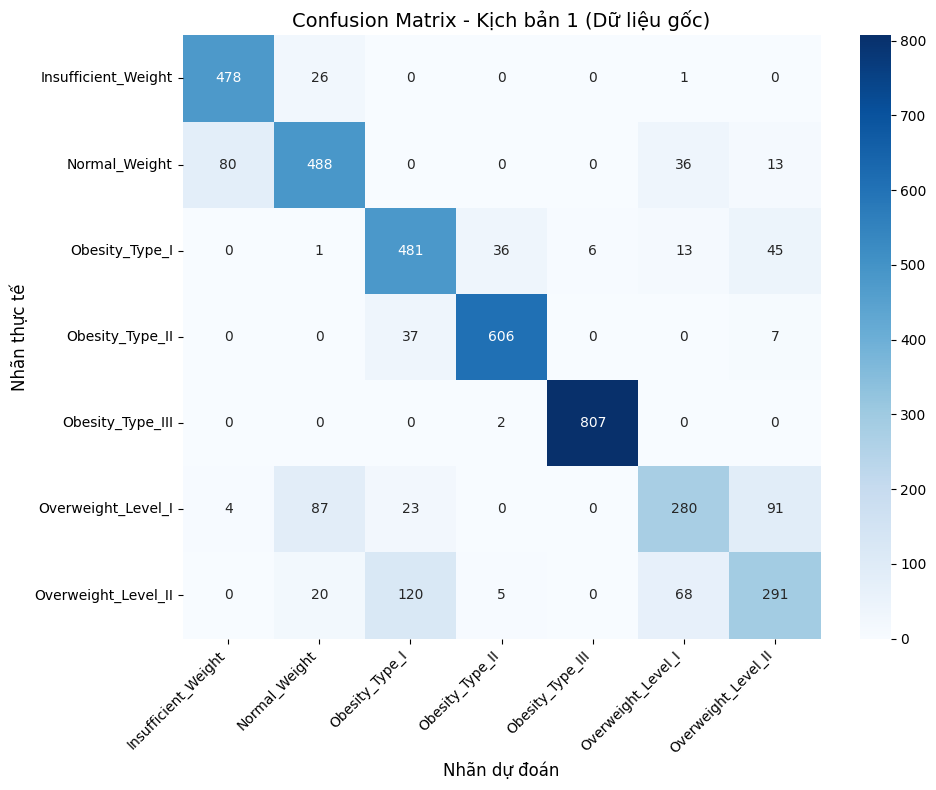

In [130]:
label_mapping = {
    0: 'Insufficient_Weight',
    1: 'Normal_Weight',
    2: 'Obesity_Type_I',
    3: 'Obesity_Type_II',
    4: 'Obesity_Type_III',
    5: 'Overweight_Level_I',
    6: 'Overweight_Level_II'
}

# Lấy danh sách tên nhãn theo thứ tự
labels = [label_mapping[i] for i in range(len(label_mapping))]

# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test_1, y_pred_1)

# Vẽ ma trận nhầm lẫn với nhãn đầy đủ
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=labels, yticklabels=labels
)

plt.title('Confusion Matrix - Kịch bản 1 (Dữ liệu gốc)', fontsize=14)
plt.xlabel('Nhãn dự đoán', fontsize=12)
plt.ylabel('Nhãn thực tế', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()